# VQE for the mini-BMN system with 2 matrices in SU(2)

How to use the Variational Quantum Eigensolver (VQE) in `qiskit` to find the ground state of a matrix model.

# SU(2) mini-BMN Hamiltonians





The following cell defines a function which creates the bosons, then it creates the SU(2) mini-BMN Hamiltonian. 
The function receives the number of bosons ($n_b$), the number of fermions ($n_f$), and the size of the bosons ($n$) as arguments.
For example, for 6 bosons that are $2 \times 2$ and 3 fermions, the function call would look like `bosonHamiltonians(6, 3, 8)`.
The function returns four Hamiltonians.

- First, an annihilation operator and identity matrix are created. Each of the 6 bosons are constructed by taking the Kronecker product of the annihilation operator with the identity matrix, in a specific order. For the $n^{th}$ boson, the annhiliation operator will be the $n^{th}$ term of the Kronecker product. Note that for an $n \times n$ boson, the identity matrix and annhilation operator are $n \times n$. The last term in the Kronecker product is an identity matrix of size $2^{n_f} \times 2^{n_f}$.
- For example, the first boson's Kronecker product would look like 
$$\hat{a}_n \otimes I_n \otimes I_n \otimes I_n \otimes I_n \otimes I_n \otimes I_{2^{n_f}}$$
where $\hat{a}$ is the annihilation operator and $I$ is the identity matrix and the subscript denotes the size of the matrix (subscript n means it has size $n \times n$ and subscript $2^{n_f}$ means it has size $2^{n_f} \times 2^{n_f}$).
- The 2nd boson would look like
$$I_n \otimes \hat{a}_n \otimes I_n \otimes I_n \otimes I_n \otimes I_n \otimes I_{2^{n_f}}$$
- Each of the 3 fermions are constructed by taking the Kronecker product of the annihilation operator with the identity matrix and Pauli `Z` matrix, in a specific order. Note that the annihilation operator and identity matrix are always size $2 \times 2$. The first term in the Kronecker product is an identity matrix of size $n^{n_b} \times n^{nb}$, where again, $n \times n$ is the boson size. For the $n^{th}$ fermion, the annhiliation operator will be the $n+1$ term of the Kronecker product and it will be followed by identity matrices and preceded by Pauli Z matrices.
- For example, the first fermion will look like
$$I_{n^{n_b}} \otimes \hat{a}_2 \otimes I_2 \otimes I_2$$
where, the subscript $2$ denotes a size of $2 \times 2$.
- The second fermion will look like 
$$I_{n^{n_b}} \otimes Z \otimes \hat{a}_2 \otimes I_2$$
where $Z$ is the Pauli `Z` matrix.
- The third fermion will look like 
$$I_{n^{n_b}} \otimes Z \otimes Z \otimes \hat{a}_2$$


## We do not have `qutip` here so we build the primitive operators using sparse arrays

In [64]:
import numpy as np
from scipy.sparse import diags
from scipy.sparse import identity
from scipy.sparse import kron

L = 2  # cutoff for Fock space -> can not go larger than 2 in qiskit without having problems for miniBMN


The annihilation operator for the single boson

In [65]:
a_b = diags(np.sqrt(np.linspace(1,L-1,L-1)),offsets=1)
a_b.todense()

matrix([[0., 1.],
        [0., 0.]])

The identity operator of the Fock space of a single boson

In [66]:
i_b = identity(L)
i_b.todense()

matrix([[1., 0.],
        [0., 1.]])

The annihilation operator for the fermions (always cutoff = 2 because it is a spin)

In [67]:
a_f = diags(np.sqrt(np.linspace(1,1,1)),offsets=1)
a_f.todense()

matrix([[0., 1.],
        [0., 0.]])

The Pauli $\sigma_z$ matrix

In [68]:
sz = diags([1.0,-1.0])
sz.todense()

matrix([[ 1.,  0.],
        [ 0., -1.]])

Identity for the single fermion space

In [69]:
i_f = identity(2)
i_f.todense()

matrix([[1., 0.],
        [0., 1.]])

## Bosonic Hilbert space

In [70]:
N_bos = 6  # number of boson sites -> fixed for mini-BMN 2

In [71]:
product_list = [i_b] * N_bos  # only the identity for bosons repeated N_bos times
a_b_list = []  # this will contain a1...a6
for i in np.arange(0,N_bos):  # loop over all bosonic operators
    operator_list = product_list.copy()  # all elements are the identity operator
    operator_list[i] = a_b  # the i^th element is now the annihilation operator for a single boson
    a_b_list.append(operator_list[0]) # start taking tensor products from first element
    for a in operator_list[1:]:
        a_b_list[i] = kron(a_b_list[i],a)  # do the outer product between each operator_list element

In [72]:
len(a_b_list)

6

## Fermionic Hilbert space

In [73]:
N_f = 3  # number of fermionic sites -> fixed for the supersymmetric model mini-BMN with 2 matrices 

In [74]:
product_list = [i_f] * N_f  # only the identity for fermions repeated N_f times
a_f_list = []  # this will contain f1...f3
for i in np.arange(0,N_f):  # loop over all bosonic operators
    operator_list = product_list.copy()  # all elements are the identity operator
    operator_list[i] = a_f  # the i^th element is now the annihilation operator for a single fermion
    for j in np.arange(0,i):  # the 0:(i-1) elements are replaced by sigma_Z
        operator_list[j] = sz
    a_f_list.append(operator_list[0])  # start taking tensor products from the first operator
    for a in operator_list[1:]:
        a_f_list[i] = kron(a_f_list[i],a)  # do the outer product 

## Combine the Bosonic and Fermionic spaces

- Identity for bosonic space (dimension will be $L^{N_{bos}} \times L^{N_{bos}}$)

In [75]:
i_b_tot = identity(L**N_bos) 

- Identity for fermionic space (dimension will be $2^{N_f} \times 2^{N_f}$)

In [76]:
i_f_tot = identity(2**N_f)

The new bosonic and fermionic operators combined into one list

In [77]:
op_list = []
for a in a_b_list:
    op_list.append(kron(a,i_f_tot))
for a in a_f_list:
    op_list.append(kron(i_b_tot,a))

In [78]:
len(op_list)

9

In [79]:
op_list[0]

<512x512 sparse matrix of type '<class 'numpy.float64'>'
	with 8192 stored elements in COOrdinate format>

## Build the Hamiltonian

Start piece by piece

- Precompute the position operators

In [80]:
x_list = []
# only use the bosonic operators
bosons = op_list[:N_bos]
for op in bosons:
    x_list.append(1/np.sqrt(2)*(op.conjugate().transpose() + op))

In [81]:
# save the fermions operators for convenience in a new list
fermions = op_list[-N_f:]

### Free Hamiltonian

In [82]:
# Create the simple quartic Hamiltonian.
H_k = 0

for a in op_list[:N_bos]:
    H_k = H_k + a.conjugate().transpose() * a

for a in op_list[-N_f:]:
    H_k = H_k + (3.0 / 2) * a.conjugate().transpose() * a

# vacuum energy
H_k = H_k + 0.25 * (2 * N_bos - 3 * N_f - 3)



- Test the construction by computing the eigenvalues (use sparse linear algebra operations for symmetric matrices)

In [83]:
from scipy.sparse.linalg import eigsh
eigv = eigsh(H_k,k=10,which='SA',return_eigenvectors=False,tol=0)

In [84]:
print(f"Free Hamiltonian eigenvalues: {eigv[::-1]}")

Free Hamiltonian eigenvalues: [-6.17472838e-16  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.50000000e+00
  1.50000000e+00  1.50000000e+00]


### Interaction among bosons

In [85]:
V_b = (
    x_list[2] * x_list[2] * x_list[3] * x_list[3]
    + x_list[2] * x_list[2] * x_list[4] * x_list[4]
    + x_list[1] * x_list[1] * x_list[3] * x_list[3]
    + x_list[1] * x_list[1] * x_list[5] * x_list[5]
    + x_list[0] * x_list[0] * x_list[4] * x_list[4]
    + x_list[0] * x_list[0] * x_list[5] * x_list[5]
    - 2 * x_list[0] * x_list[2] * x_list[3] * x_list[5]
    - 2 * x_list[0] * x_list[1] * x_list[3] * x_list[4]
    - 2 * x_list[1] * x_list[2] * x_list[4] * x_list[5]
)

### Interactions between bosons and fermions

In [86]:
V_bf = (2j / np.sqrt(2)) * (
    (x_list[0] - 1j * x_list[3])
    * fermions[1].conjugate().transpose()
    * fermions[2].conjugate().transpose()
    + (x_list[1] - 1j * x_list[4])
    * fermions[2].conjugate().transpose()
    * fermions[0].conjugate().transpose()
    + (x_list[2] - 1j * x_list[5])
    * fermions[0].conjugate().transpose()
    * fermions[1].conjugate().transpose()
    - (x_list[0] + 1j * x_list[3]) * fermions[2] * fermions[1]
    - (x_list[1] + 1j * x_list[4]) * fermions[0] * fermions[2]
    - (x_list[2] + 1j * x_list[5]) * fermions[1] * fermions[0]
)

### Mini BMN2 Hamiltonian

In [87]:
# t'Hooft coupling
g2N = 0.2
# Number of colors
N = 2
# full hamiltonian
H = H_k + g2N/N*V_b + np.sqrt(g2N/N)*V_bf

In [88]:
H.shape

(512, 512)

In [89]:
eigv = eigsh(H,k=10,which='SM',return_eigenvectors=False,tol=0)

In [90]:
print(f"Full Hamiltonian with lambda={g2N} : {eigv[::-1]}")

Full Hamiltonian with lambda=0.2 : [0.00328726 0.95978401 0.95978401 0.95978401 1.00188691 1.00188691
 1.00188691 1.59620668 1.59620668 1.59620668]


## Use QISKIT to solve the problem with quantum algorithms

### Convert the Hamiltonian

Now, we take the Hamiltonian matrix and map it onto a qubit operator. There may be better ways to do this now that Qiskit has added new ways to map Hamiltonians to qubit operators.

In [91]:
import warnings
import time
from qiskit.opflow import MatrixOp

start_time = time.time()
warnings.filterwarnings("ignore")

qubitOp = MatrixOp(primitive=H)

print("Size of Hamiltonian:", np.shape(H))
# do not print when size of bosonic matrix is >2
# print(qubitOp)
end_time = time.time()

runtime = end_time-start_time
print('Program runtime: ',runtime)

Size of Hamiltonian: (512, 512)
Operator([[ 0.15+0.j,  0.  +0.j,  0.  +0.j, ...,  0.  +0.j,  0.  +0.j,
            0.  +0.j],
          [ 0.  +0.j,  1.65+0.j,  0.  +0.j, ...,  0.  +0.j,  0.  +0.j,
            0.  +0.j],
          [ 0.  +0.j,  0.  +0.j,  1.65+0.j, ...,  0.  +0.j,  0.  +0.j,
            0.  +0.j],
          ...,
          [ 0.  +0.j,  0.  +0.j,  0.  +0.j, ...,  9.15+0.j,  0.  +0.j,
            0.  +0.j],
          [ 0.  +0.j,  0.  +0.j,  0.  +0.j, ...,  0.  +0.j,  9.15+0.j,
            0.  +0.j],
          [ 0.  +0.j,  0.  +0.j,  0.  +0.j, ...,  0.  +0.j,  0.  +0.j,
           10.65+0.j]],
         input_dims=(2, 2, 2, 2, 2, 2, 2, 2, 2), output_dims=(2, 2, 2, 2, 2, 2, 2, 2, 2))
Program runtime:  0.003737211227416992


Next, we create the variational form.

1.   The plot shows in purple the variational parameters used in the construction of the circuit
2.   The plot shows in blue the entanglement with control gates



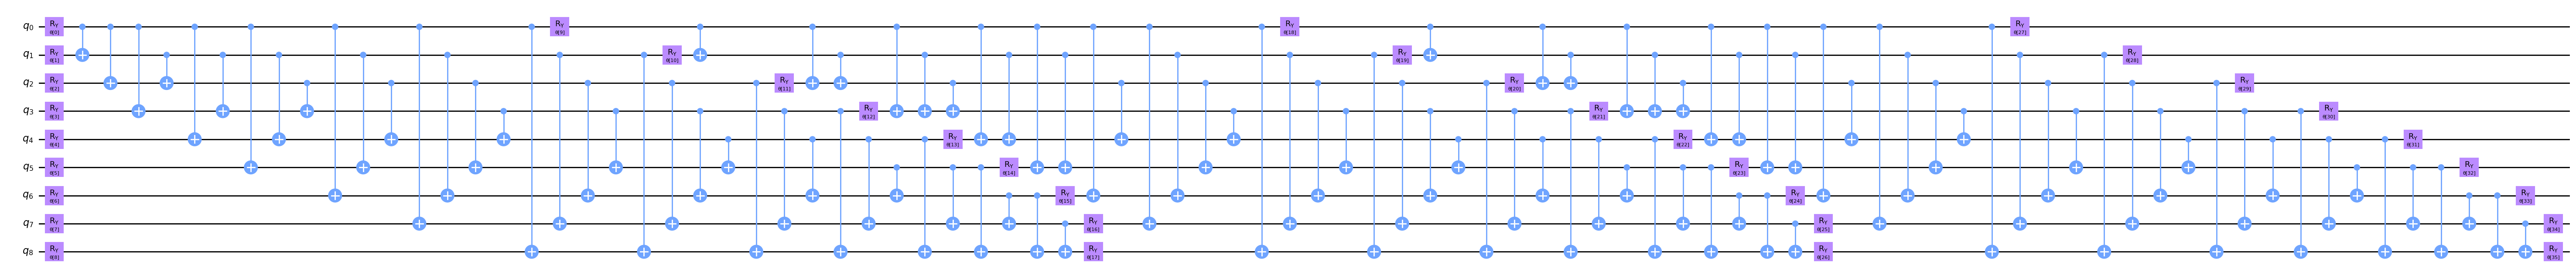

In [92]:
from qiskit.circuit.library import EfficientSU2

var_form = EfficientSU2(qubitOp.num_qubits, su2_gates=['ry'], entanglement="full", reps=3)
display(var_form.draw(output='mpl',fold=100))

In the next cell, we check the exact minimum eigenvalue of the qubit operator to make sure that our Hamiltonian mapped correctly. We should get the same classical result we have seen in the discretized case before

In [95]:
from qiskit.algorithms import NumPyEigensolver

mes = NumPyEigensolver(k=4)  # k is the number of eigenvalues to compute

result = mes.compute_eigenvalues(qubitOp)
print(result.eigenvalues)
print("Exact Result of qubit hamiltonian:", np.real(result.eigenvalues))
print("Exact Result of discrete hamiltonian:", np.real(eigv[::-1][0:4]))

[0.00328726+7.59493193e-17j 0.95978401+2.01223716e-17j
 0.95978401+1.16316124e-16j 0.95978401-5.09779651e-17j]
Exact Result of qubit hamiltonian: [0.00328726 0.95978401 0.95978401 0.95978401]
Exact Result of discrete hamiltonian: [0.00328726 0.95978401 0.95978401 0.95978401]


### Run the VQE algorithm

Now, we can run the VQE algorithm.

We can use multiple simulators from the QISKIT ecosystem:

- [A statevector simulator](https://qiskit.org/documentation/stubs/qiskit.providers.aer.StatevectorSimulator.htm)
- [A Qasm simulator](https://qiskit.org/documentation/stubs/qiskit.providers.aer.QasmSimulator.html)

In [96]:
from qiskit import Aer  # change this to Aer for C++ compiled code and the option to run on the GPU
from qiskit.algorithms import VQE

#### Statevector simulator

Example from [here](https://qiskit.org/documentation/tutorials/algorithms/02_vqe_convergence.html)

In [97]:
# start a quantum instance
# fix the random seed of the simulator to make values reproducible
from qiskit.utils import algorithm_globals, QuantumInstance
seed = 50
algorithm_globals.random_seed = seed


# with GPU
#backend = Aer.get_backend("statevector_simulator", method="statevector_gpu")
# with parallel computation restricted to 2 OpenMP threads (0: maximum)
backend = Aer.get_backend("statevector_simulator", max_parallel_threads=6, max_parallel_experiments=0)

q_instance = QuantumInstance(backend, seed_transpiler=seed, seed_simulator=seed)


In [103]:
from qiskit.algorithms.optimizers import SLSQP, COBYLA, L_BFGS_B, NELDER_MEAD, SPSA

start_time = time.time()
# choose one classical optimizer
# optimizer = L_BFGS_B(maxiter=5000)
# optimizer = SPSA(maxiter=5000)
optimizer = COBYLA(maxiter=5000)

counts = []
values = []
# callback functions to store the counts from each iteration of the VQE
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

# initital points
#random_init = np.random.random(var_form.num_parameters)
#fixed_init = result.optimal_point

# Setup the VQE algorithm
#vqe = VQE(ansatz=var_form, optimizer=optimizer, initial_point=random_init, quantum_instance=q_instance, callback=store_intermediate_result)
#vqe = VQE(ansatz=var_form, optimizer=optimizer, initial_point=fixed_init, quantum_instance=q_instance, callback=store_intermediate_result)
vqe = VQE(ansatz=var_form, optimizer=optimizer, quantum_instance=q_instance, callback=store_intermediate_result)

# run the VQE with out Hamiltonian operator
# since the VQE is a ground state solver, the syntax is the same as before ;-)
result = vqe.compute_minimum_eigenvalue(qubitOp)
vqe_result = np.real(result.eigenvalue)
print("VQE Result:", vqe_result)

end_time = time.time()
runtime = end_time-start_time
print('Program runtime:',runtime, "s")

VQE Result: 0.1268454957761042
Program runtime: 111.24805283546448 s


Sometimes these results are very bad...we do not get anything close to 0.5

Finally, we plot a convergence plot of the VQE results.

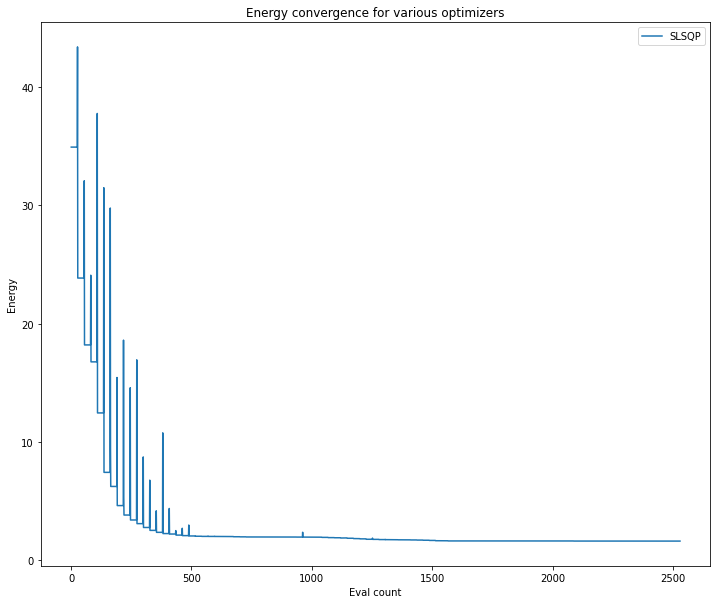

In [ ]:
# Plot convergence plot
plt.figure(figsize=(12,10))
plt.plot(counts, values, label="SLSQP")
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Energy convergence for various optimizers')
plt.legend(loc='upper right')

#### QASM simulator

Example from [here](https://qiskit.org/documentation/tutorials/algorithms/03_vqe_simulation_with_noise.html#Performance-without-noise)

In [ ]:
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua import QuantumInstance


start_time = time.time()
warnings.filterwarnings("ignore")

backendQasm = Aer.get_backend('qasm_simulator', method="statevector_gpu")
quantum_instance = QuantumInstance(backend=backendQasm, shots=1024)
optimizer = SPSA(max_trials=600)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

# Run the VQE
vqe = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)
ret = vqe.run(quantum_instance)
vqe_result = np.real(ret['eigenvalue'])
print("VQE Result:", vqe_result)
end_time = time.time()

runtime = end_time-start_time
print('Program runtime:',runtime, "s")

VQE Result: 2.5247894634219064
Program runtime: 1298.9465007781982 s


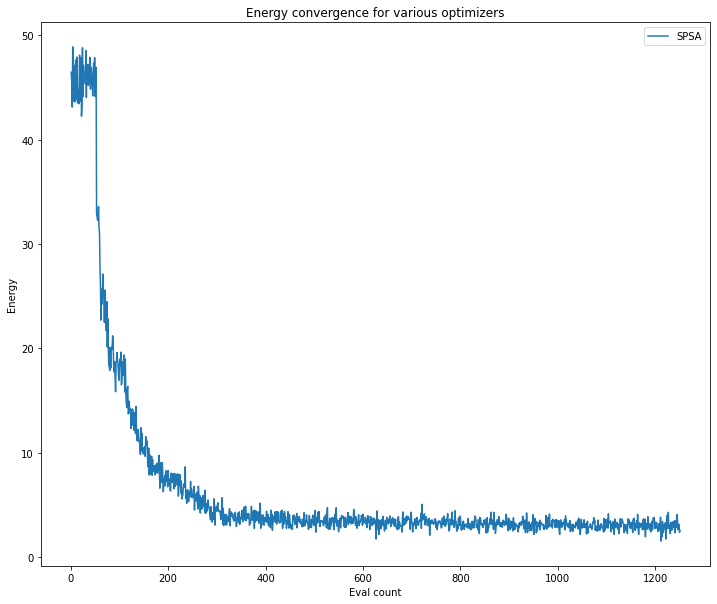

In [ ]:
# Plot convergence plot
plt.figure(figsize=(12,10))
plt.plot(counts, values, label="SPSA")
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Energy convergence for various optimizers')
plt.legend(loc='upper right')

In [ ]:
start_time = time.time()
warnings.filterwarnings("ignore")

backendQasm = Aer.get_backend('qasm_simulator', max_parallel_threads=4, max_parallel_experiments=0)
quantum_instance = QuantumInstance(backend=backendQasm, shots=1024)
optimizer = SPSA(max_trials=600)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

# Run the VQE
vqe = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)
ret = vqe.run(quantum_instance)
vqe_result = np.real(ret['eigenvalue'])
print("VQE Result:", vqe_result)
end_time = time.time()

runtime = end_time-start_time
print('Program runtime:',runtime, "s")

VQE Result: 2.080651876586261
Program runtime: 1223.4481608867645 s


In [101]:
import qiskit.tools.jupyter
%qiskit_version_table